# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [2]:
import pandas as pd

In [4]:

x_train= pd.read_csv(r"D:\Documents\An 2\05. Machine learning\ubb-sociology-ml\final_project\data_X_train.csv")
x_test= pd.read_csv(r"D:\Documents\An 2\05. Machine learning\ubb-sociology-ml\final_project\data_X_test.csv")
y_train= pd.read_csv(r"D:\Documents\An 2\05. Machine learning\ubb-sociology-ml\final_project\variable_y_train.csv")
y_test= pd.read_csv(r"D:\Documents\An 2\05. Machine learning\ubb-sociology-ml\final_project\variable_y_train.csv")



In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')




y_train_mean = y_train.mean()

y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_train_mean)

In [18]:
print("=" * 100)
print("REGRESSION MODELING PIPELINE: Predicting Hours-per-Week")
print("=" * 100)

# Set random seeds for reproducibility
np.random.seed(42)

REGRESSION MODELING PIPELINE: Predicting Hours-per-Week


In [17]:
print(f"\nDataset Shapes:")
print(f"X_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")


Dataset Shapes:
X_train: (24111, 80), y_train: (24111, 1)
X_test: (6028, 80), y_test: (24111, 1)


In [21]:
# Create validation set from training data
x_train, X_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)
print(f"\nAfter validation split:")
print(f"X_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")


After validation split:
X_train: (19288, 80), y_train: (19288, 1)
X_val: (4823, 80), y_val: (4823, 1)
X_test: (6028, 80), y_test: (24111, 1)


In [31]:
print("\n" + "="*100)
print("2. MODEL SELECTION AND SETUP")
print("="*100)

# Define models with justifications
models = {
    'SGD_Regressor': {
        'model': SGDRegressor(random_state=42, max_iter=1000, tol=1e-3),
        'loss': 'squared_error',
        'requires_scaling': True
    },
    'Decision_Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'requires_scaling': False
    },
    'Random_Forest': {
        'model': RandomForestRegressor(random_state=42, n_estimators=100),
        'requires_scaling': False
    },
    'Ridge_Regression': {
        'model': Ridge(random_state=42),
        'requires_scaling': True
    },
    'Lasso_Regression': {
        'model': Lasso(random_state=42, max_iter=10000),
        'requires_scaling': True
    }
}



2. MODEL SELECTION AND SETUP


In [27]:
from sklearn.preprocessing import StandardScaler

In [32]:
lin_reg = LinearRegression()

# Ajustam modelul pe datele de antrenare
lin_reg.fit(x_train, y_train)

# Printam coeficientii modelului
print(lin_reg.intercept_, '\n', lin_reg.coef_)



[31.65479185] 
 [[-1.66979919e-01  1.75082887e+00  1.07142800e+00  2.69339038e-01
   9.39191790e-02 -6.20756711e+00  8.68116747e+00  1.48091171e+00
  -1.11960045e+00 -1.35212314e+00 -1.00476257e+00 -3.43629349e+00
   4.73957812e+00  1.27213122e+00  3.24146444e+00  7.75835745e+00
  -2.77344654e-01  1.42660879e+00 -1.84936475e+00  3.40336071e-01
   3.55412706e-01  1.87388102e+00  1.84675642e+00 -9.31738639e-01
   3.85394755e+00  2.47817201e+00  9.62171832e-01 -2.30250669e+00
   1.90072771e+00 -3.98453099e+00 -5.99864741e-01 -2.67423828e-01
  -5.93830282e-02  6.20006312e-02  2.62991242e+00  1.07289807e+00
   4.85320498e-01  2.39655044e+00  1.05570522e+00  7.05735617e+00
   2.48359912e+00  7.19166366e-01  3.08163253e+00  2.66235961e+00
   1.97324746e+00  5.60762681e+00  2.05340255e+00  1.98989255e+00
   3.55271368e-15  2.01367649e+00  5.70242970e-01 -4.11436274e+00
   1.36554298e+00  2.44767924e+00  3.56418954e+00  2.43426228e+00
   1.30236452e+00  3.93283257e+00  5.80964456e+00  2.9676642

In [34]:
y_prediction = lin_reg.predict(x_test)

In [41]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=5, random_state=42) 
DecisionTree = dtr.fit(x_train, y_train)
y_prediction = dtr.predict(x_test)

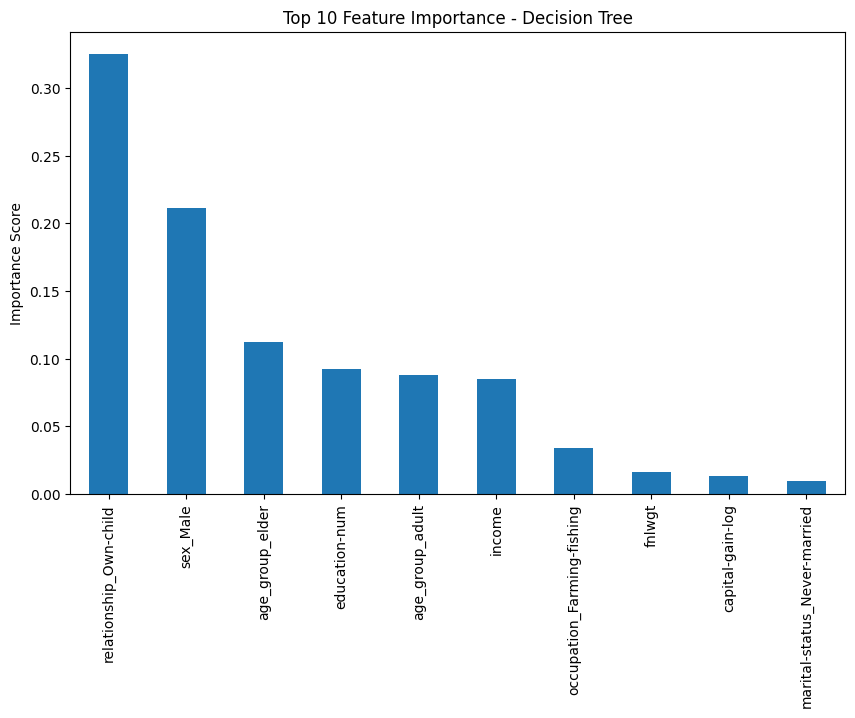

In [43]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

importances = dtr.feature_importances_
feature_names = x_train.columns
tree_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
tree_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.ylabel('Importance Score')
plt.show()